<a href="https://colab.research.google.com/github/AndresInsuasty/tesis-cafes-especiales/blob/main/pix2pixNDVI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pix2pix para segmentado de imagenes NDVI


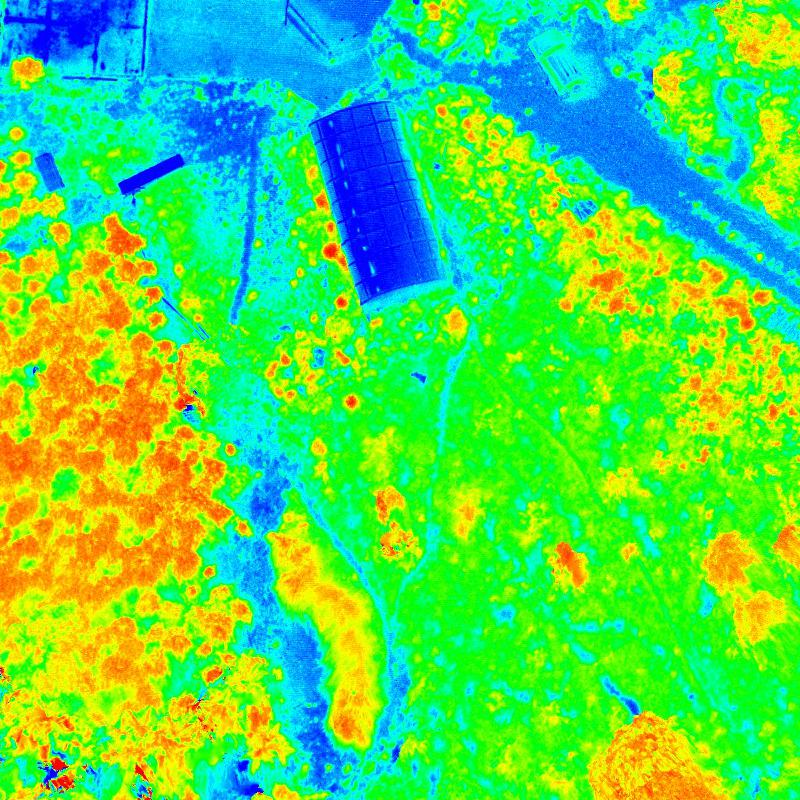



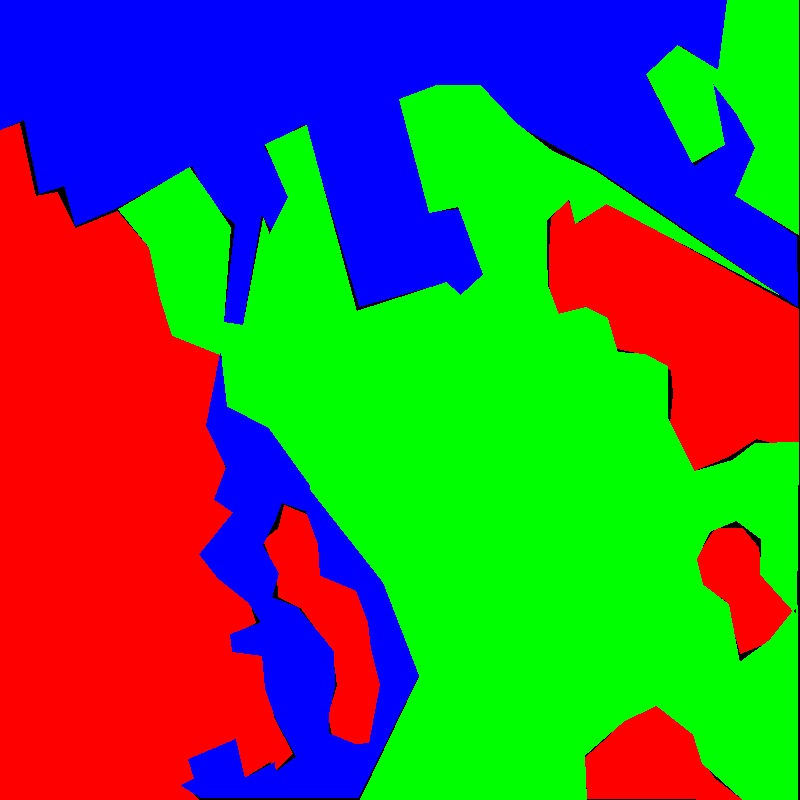{ width: 200px; }

## Librerias

In [64]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from glob import glob

In [65]:
# Ruta raiz
PATH = "/content/drive/MyDrive/segmentado/pix2pix"

# Ruta de datos de entrada
INPATH = PATH + '/imagenes_ndvi/'
# Ruta de salida
OUTPATH = PATH + '/imagenes_segmentadas/'
# Ruta de los checkpoints
CKPATH = PATH + '/chechpoints'

## Listar Archivos

In [66]:
def ls_path(path, filtro="*.jpg"):
    spath=path + filtro
    a=glob(spath)
    return     

In [67]:
#imgurls = ls_path(INPATH)
imgurls = !ls -1 "{INPATH}"

## Particionar Dataset

In [68]:
 n = len(imgurls)
 train_n = round(n*0.8)
 
 # Particion Train/Test
 tr_urls = imgurls[:train_n]
 ts_urls = imgurls[train_n:n]

In [69]:
print('El tamaño total del dataset es {} \n Entrenamiento: {} \n Testeo: {} '.format(len(imgurls),len(tr_urls),len(ts_urls)))

El tamaño total del dataset es 301 
 Entrenamiento: 241 
 Testeo: 60 


## Funciones de preprocesado de imagenes

In [79]:
IMG_WIDTH = 256
IMG_HEIGHT = 256

# Reescalar imagenes
def resize(inimg,tgimg, height,width):
    inimg = tf.image.resize(inimg,[height,width])
    tgimg = tf.image.resize(tgimg,[height,width])

    return inimg,tgimg

# Normalizar el rango [-1, +1] la imagen
def normalize(inimg,tgimg):
    inimg = (inimg/127.5)-1
    tgimg = (tgimg/127.5)-1

    return inimg,tgimg

@tf.function()
# Aumentación de datos: Random Crop + Flip
def random_jitter(inimg,tgimg):
    inimg,tgimg = resize(inimg,tgimg,286,286)

    stacked_image = tf.stack([inimg,tgimg],axis=0)
    croppped_image = tf.image.random_crop(stacked_image,size=[2,IMG_WIDTH,IMG_HEIGHT,3])

    inimg,tgimg = croppped_image[0], croppped_image[1]

    if tf.random.uniform(())>0.5:
        inimg = tf.image.flip_left_right(inimg)
        tgimg = tf.image.flip_left_right(tgimg)

    return inimg,tgimg

# carga de imagenes dataset
def load_image(filename, augment=True):
    inimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(INPATH + '/' + filename)),tf.float32)
    tgimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(OUTPATH + '/' + filename)),tf.float32)
    
    inimg, tgimg = resize(inimg, tgimg, IMG_WIDTH, IMG_HEIGHT)
    
    if augment:
        inimg,tgimg = random_jitter(inimg,tgimg)
    
    inimg,tgimg = normalize(inimg,tgimg)
    return inimg,tgimg

def load_train_image(filename):
    return load_image(filename,True)

def load_test_image(filename):
    return load_image(filename,False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


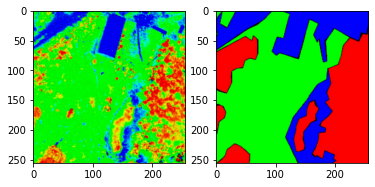

In [80]:
[ndvi,ndvi_seg] = load_train_image(tr_urls[0])
plt.subplot(121)
plt.imshow(ndvi)
plt.subplot(122)
plt.imshow(ndvi_seg)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


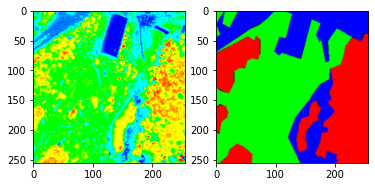

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


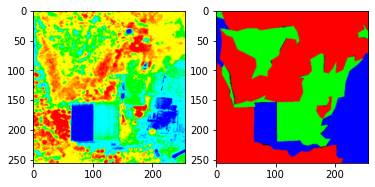

In [83]:
train_dataset = tf.data.Dataset.from_tensor_slices(tr_urls)
train_dataset = train_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(1)

for inimg, tgimg in train_dataset.take(2):
    plt.subplot(121)
    plt.imshow(np.squeeze(inimg)+1/2)
    plt.subplot(122)
    plt.imshow((np.squeeze(tgimg)+1)/2)
    plt.show()